<a href="https://colab.research.google.com/github/LPugens/Learning/blob/master/Notebooks/03_DeepLearning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [145]:
import pandas as pd
import seaborn as sns
import sklearn
from sklearn import preprocessing
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np

#Deep Learning
Aqui nós vamos tentar desenvolver um algoritmo de deep-learning que conseguirá predizer os MoAs, dada a assinatura de ativação genética do experimento.

Nós vamos fazer uso das ferramentas de deep-learning da biblioteca Tensorflow

![deep-learning](https://raw.githubusercontent.com/LPugens/imersao-dados-desafio-final/main/fig3_deep_learning.jpg)

Fonte [Artigo da Science](https://www.nature.com/articles/nrd.2017.232.pdf?origin=ppub)

##Carregando os dados

In [146]:
dados_experimentos = 'https://github.com/LPugens/imersao-dados-desafio-final/blob/main/Dados/dados_experimentos.zip?raw=true'
dados_experimentos = pd.read_csv(dados_experimentos, compression = 'zip')
dados_experimentos.head()

,id,tratamento,tempo,dose,droga,g-0,g-1,g-2,g-3,g-4,g-5,g-6,g-7,g-8,g-9,g-10,g-11,g-12,g-13,g-14,g-15,g-16,g-17,g-18,g-19,g-20,g-21,g-22,g-23,g-24,g-25,g-26,g-27,g-28,g-29,g-30,g-31,g-32,g-33,g-34,...,c-60,c-61,c-62,c-63,c-64,c-65,c-66,c-67,c-68,c-69,c-70,c-71,c-72,c-73,c-74,c-75,c-76,c-77,c-78,c-79,c-80,c-81,c-82,c-83,c-84,c-85,c-86,c-87,c-88,c-89,c-90,c-91,c-92,c-93,c-94,c-95,c-96,c-97,c-98,c-99
0,id_000644bb2,com_droga,24,D1,b68db1d53,1.0620,0.5577,-0.2479,-0.6208,-0.1944,-1.0120,-1.0220,-0.0326,0.5548,-0.0921,1.1830,0.1530,0.5574,-0.4015,0.1789,-0.6528,-0.7969,0.6342,0.1778,-0.3694,-0.5688,-1.1360,-1.1880,0.6940,0.4393,0.2664,0.1907,0.1628,-0.2853,0.5819,0.2934,-0.5584,-0.0916,-0.3010,-0.1537,...,0.4805,0.4965,0.3680,0.8427,0.1042,0.1403,0.1758,1.2570,-0.5979,1.2250,-0.0553,0.7351,0.5810,0.9590,0.2427,0.0495,0.4141,0.8432,0.6162,-0.7318,1.2120,0.6362,-0.4427,0.1288,1.4840,0.1799,0.5367,-0.1111,-1.0120,0.6685,0.2862,0.2584,0.8076,0.5523,-0.1912,0.6584,-0.3981,0.2139,0.3801,0.4176
1,id_000779bfc,com_droga,72,D1,df89a8e5a,0.0743,0.4087,0.2991,0.0604,1.0190,0.5207,0.2341,0.3372,-0.4047,0.8507,-1.1520,-0.4201,-0.0958,0.4590,0.0803,0.2250,0.5293,0.2839,-0.3494,0.2883,0.9449,-0.1646,-0.2657,-0.3372,0.3135,-0.4316,0.4773,0.2075,-0.4216,-0.1161,-0.0499,-0.2627,0.9959,-0.2483,0.2655,...,0.4083,0.0319,0.3905,0.7099,0.2912,0.4151,-0.2840,-0.3104,-0.6373,0.2887,-0.0765,0.2539,0.4443,0.5932,0.2031,0.7639,0.5499,-0.3322,-0.0977,0.4329,-0.2782,0.7827,0.5934,0.3402,0.1499,0.4420,0.9366,0.8193,-0.4236,0.3192,-0.4265,0.7543,0.4708,0.0230,0.2957,0.4899,0.1522,0.1241,0.6077,0.7371
2,id_000a6266a,com_droga,48,D1,18bb41b2c,0.6280,0.5817,1.5540,-0.0764,-0.0323,1.2390,0.1715,0.2155,0.0065,1.2300,-0.4797,-0.5631,-0.0366,-1.8300,0.6057,-0.3278,0.6042,-0.3075,-0.1147,-0.0570,-0.0799,-0.8181,-1.5320,0.2307,0.4901,0.4780,-1.3970,4.6240,-0.0437,1.2870,-1.8530,0.6069,0.4290,0.1783,0.0018,...,-0.5477,-0.7576,-0.0444,0.1894,-0.0014,-2.3640,-0.4682,0.1210,-0.5177,-0.0604,0.1682,-0.4436,0.4963,0.1363,0.3335,0.9760,-0.0427,-0.1235,0.0959,0.0690,-0.9416,-0.7548,-0.1109,-0.6272,0.3019,0.1172,0.1093,-0.3113,0.3019,-0.0873,-0.7250,-0.6297,0.6103,0.0223,-1.3240,-0.3174,-0.6417,-0.2187,-1.4080,0.6931
3,id_0015fd391,com_droga,48,D1,8c7f86626,-0.5138,-0.2491,-0.2656,0.5288,4.0620,-0.8095,-1.9590,0.1792,-0.1321,-1.0600,-0.8269,-0.3584,-0.8511,-0.5844,-2.5690,0.8183,-0.0532,-0.8554,0.1160,-2.3520,2.1200,-1.1580,-0.7191,-0.8004,-1.4670,-0.0107,-0.8995,0.2406,-0.2479,-1.0890,-0.7575,0.0881,-2.7370,0.8745,0.5787,...,-2.1220,-0.3752,-2.3820,-3.7350,-2.9740,-1.4930,-1.6600,-3.1660,0.2816,-0.2990,-1.1870,-0.5044,-1.7750,-1.6120,-0.9215,-1.0810,-3.0520,-3.4470,-2.7740,-1.8460,-0.5568,-3.3960,-2.9510,-1.1550,-3.2620,-1.5390,-2.4600,-0.9417,-1.5550,0.2431,-2.0990,-0.6441,-5.6300,-1.3780,-0.8632,-1.2880,-1.6210,-0.8784,-0.3876,-0.8154
4,id_001626bd3,com_droga,72,D2,7cbed3131,-0.3254,-0.4009,0.9700,0.6919,1.4180,-0.8244,-0.2800,-0.1498,-0.8789,0.8630,-0.2219,-0.5121,-0.9577,1.1750,0.2042,0.1970,0.1244,-1.7090,-0.3543,-0.5160,-0.3330,-0.2685,0.7649,0.2057,1.3720,0.6835,0.8056,-0.3754,-1.2090,0.2965,-0.0712,0.6389,0.6674,-0.0783,1.1740,...,-0.2274,0.3215,0.1535,-0.4640,-0.5943,0.3973,0.1500,0.5178,0.5159,0.6091,0.1813,-0.4249,0.7832,0.6529,0.5648,0.4817,0.0587,0.5303,0.6376,-0.3966,-1.4950,-0.9625,-0.0541,0.6273,0.4563,0.0698,0.8134,0.1924,0.6054,-0.1824,0.0042,0.0048,0.6670,1.0690,0.5523,-0.3031,0.1094,0.2885,-0.3786,0.7125


In [147]:
dados_resultados = 'https://github.com/LPugens/imersao-dados-desafio-final/blob/main/Dados/dados_resultados.csv?raw=true'
dados_resultados = pd.read_csv(dados_resultados)
dados_resultados.head()

,id,5-alpha_reductase_inhibitor,11-beta-hsd1_inhibitor,acat_inhibitor,acetylcholine_receptor_agonist,acetylcholine_receptor_antagonist,acetylcholinesterase_inhibitor,adenosine_receptor_agonist,adenosine_receptor_antagonist,adenylyl_cyclase_activator,adrenergic_receptor_agonist,adrenergic_receptor_antagonist,akt_inhibitor,aldehyde_dehydrogenase_inhibitor,alk_inhibitor,ampk_activator,analgesic,androgen_receptor_agonist,androgen_receptor_antagonist,anesthetic_-_local,angiogenesis_inhibitor,angiotensin_receptor_antagonist,anti-inflammatory,antiarrhythmic,antibiotic,anticonvulsant,antifungal,antihistamine,antimalarial,antioxidant,antiprotozoal,antiviral,apoptosis_stimulant,aromatase_inhibitor,atm_kinase_inhibitor,atp-sensitive_potassium_channel_antagonist,atp_synthase_inhibitor,atpase_inhibitor,atr_kinase_inhibitor,aurora_kinase_inhibitor,...,protein_synthesis_inhibitor,protein_tyrosine_kinase_inhibitor,radiopaque_medium,raf_inhibitor,ras_gtpase_inhibitor,retinoid_receptor_agonist,retinoid_receptor_antagonist,rho_associated_kinase_inhibitor,ribonucleoside_reductase_inhibitor,rna_polymerase_inhibitor,serotonin_receptor_agonist,serotonin_receptor_antagonist,serotonin_reuptake_inhibitor,sigma_receptor_agonist,sigma_receptor_antagonist,smoothened_receptor_antagonist,sodium_channel_inhibitor,sphingosine_receptor_agonist,src_inhibitor,steroid,syk_inhibitor,tachykinin_antagonist,tgf-beta_receptor_inhibitor,thrombin_inhibitor,thymidylate_synthase_inhibitor,tlr_agonist,tlr_antagonist,tnf_inhibitor,topoisomerase_inhibitor,transient_receptor_potential_channel_antagonist,tropomyosin_receptor_kinase_inhibitor,trpv_agonist,trpv_antagonist,tubulin_inhibitor,tyrosine_kinase_inhibitor,ubiquitin_specific_protease_inhibitor,vegfr_inhibitor,vitamin_b,vitamin_d_receptor_agonist,wnt_inhibitor
0,id_000644bb2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,id_000779bfc,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,id_000a6266a,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,id_0015fd391,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,id_001626bd3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


##Pré-processamento dos dados

Unindo os dados dos experimentos e dados dos resultados em um único DataFrame.

In [148]:
dados = pd.merge(left=dados_experimentos, right=dados_resultados, on='id')
dados.head()

,id,tratamento,tempo,dose,droga,g-0,g-1,g-2,g-3,g-4,g-5,g-6,g-7,g-8,g-9,g-10,g-11,g-12,g-13,g-14,g-15,g-16,g-17,g-18,g-19,g-20,g-21,g-22,g-23,g-24,g-25,g-26,g-27,g-28,g-29,g-30,g-31,g-32,g-33,g-34,...,protein_synthesis_inhibitor,protein_tyrosine_kinase_inhibitor,radiopaque_medium,raf_inhibitor,ras_gtpase_inhibitor,retinoid_receptor_agonist,retinoid_receptor_antagonist,rho_associated_kinase_inhibitor,ribonucleoside_reductase_inhibitor,rna_polymerase_inhibitor,serotonin_receptor_agonist,serotonin_receptor_antagonist,serotonin_reuptake_inhibitor,sigma_receptor_agonist,sigma_receptor_antagonist,smoothened_receptor_antagonist,sodium_channel_inhibitor,sphingosine_receptor_agonist,src_inhibitor,steroid,syk_inhibitor,tachykinin_antagonist,tgf-beta_receptor_inhibitor,thrombin_inhibitor,thymidylate_synthase_inhibitor,tlr_agonist,tlr_antagonist,tnf_inhibitor,topoisomerase_inhibitor,transient_receptor_potential_channel_antagonist,tropomyosin_receptor_kinase_inhibitor,trpv_agonist,trpv_antagonist,tubulin_inhibitor,tyrosine_kinase_inhibitor,ubiquitin_specific_protease_inhibitor,vegfr_inhibitor,vitamin_b,vitamin_d_receptor_agonist,wnt_inhibitor
0,id_000644bb2,com_droga,24,D1,b68db1d53,1.0620,0.5577,-0.2479,-0.6208,-0.1944,-1.0120,-1.0220,-0.0326,0.5548,-0.0921,1.1830,0.1530,0.5574,-0.4015,0.1789,-0.6528,-0.7969,0.6342,0.1778,-0.3694,-0.5688,-1.1360,-1.1880,0.6940,0.4393,0.2664,0.1907,0.1628,-0.2853,0.5819,0.2934,-0.5584,-0.0916,-0.3010,-0.1537,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,id_000779bfc,com_droga,72,D1,df89a8e5a,0.0743,0.4087,0.2991,0.0604,1.0190,0.5207,0.2341,0.3372,-0.4047,0.8507,-1.1520,-0.4201,-0.0958,0.4590,0.0803,0.2250,0.5293,0.2839,-0.3494,0.2883,0.9449,-0.1646,-0.2657,-0.3372,0.3135,-0.4316,0.4773,0.2075,-0.4216,-0.1161,-0.0499,-0.2627,0.9959,-0.2483,0.2655,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,id_000a6266a,com_droga,48,D1,18bb41b2c,0.6280,0.5817,1.5540,-0.0764,-0.0323,1.2390,0.1715,0.2155,0.0065,1.2300,-0.4797,-0.5631,-0.0366,-1.8300,0.6057,-0.3278,0.6042,-0.3075,-0.1147,-0.0570,-0.0799,-0.8181,-1.5320,0.2307,0.4901,0.4780,-1.3970,4.6240,-0.0437,1.2870,-1.8530,0.6069,0.4290,0.1783,0.0018,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,id_0015fd391,com_droga,48,D1,8c7f86626,-0.5138,-0.2491,-0.2656,0.5288,4.0620,-0.8095,-1.9590,0.1792,-0.1321,-1.0600,-0.8269,-0.3584,-0.8511,-0.5844,-2.5690,0.8183,-0.0532,-0.8554,0.1160,-2.3520,2.1200,-1.1580,-0.7191,-0.8004,-1.4670,-0.0107,-0.8995,0.2406,-0.2479,-1.0890,-0.7575,0.0881,-2.7370,0.8745,0.5787,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,id_001626bd3,com_droga,72,D2,7cbed3131,-0.3254,-0.4009,0.9700,0.6919,1.4180,-0.8244,-0.2800,-0.1498,-0.8789,0.8630,-0.2219,-0.5121,-0.9577,1.1750,0.2042,0.1970,0.1244,-1.7090,-0.3543,-0.5160,-0.3330,-0.2685,0.7649,0.2057,1.3720,0.6835,0.8056,-0.3754,-1.2090,0.2965,-0.0712,0.6389,0.6674,-0.0783,1.1740,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


Transoformando as features de `tempo` e `dose` em one-hot-encoding.

In [149]:
dados = pd.get_dummies(data=dados, columns=['tempo', 'dose'])

Para este experimento, vamos considerar apenas os `g`s

A features `droga` pode parecer importante até mesmo par um processamento a partir dos seus nomes em `embeddings` seria interessante. Mas como os labels estão anonimizados, não temos muito o que fazer com eles.

In [150]:
dados = dados.drop(labels=['id', 'tratamento', 'droga'], axis=1)

In [151]:
# dados = dados.filter(regex=r'^(?!c-)')

Para melhorar o desempenho dos algoritmos, é interessante normalizar os dados.

Dadas as informações do dataset, podemos normalizar os `g`s, para apresentarem média = 0 e variancia = 1

In [152]:
print(f'Média dos Gs {dados.loc[:, "g-0":"c-99"].mean()}')
print(f'Desvio padrão dos Gs {dados.loc[:, "g-0":"c-99"].std()}')

Média dos Gs g-0     0.248366
g-1    -0.095684
g-2     0.152253
g-3     0.081971
g-4     0.057347
          ...   
c-95   -0.353726
c-96   -0.463485
c-97   -0.378241
c-98   -0.470252
c-99   -0.301505
Length: 872, dtype: float64
Desvio padrão dos Gs g-0     1.393399
g-1     0.812363
g-2     1.035731
g-3     0.950012
g-4     1.032091
          ...   
c-95    1.629291
c-96    2.059725
c-97    1.703615
c-98    1.834828
c-99    1.407918
Length: 872, dtype: float64


In [153]:
scaler = preprocessing.StandardScaler().fit(dados.loc[:, 'g-0':'c-99'])
dados.loc[:, 'g-0':'c-99'] = scaler.transform(dados.loc[:, 'g-0':'c-99'])

In [154]:
print(f'Média dos Gs {dados.loc[:, "g-0":"c-99"].mean()}')
print(f'Desvio padrão dos Gs {dados.loc[:, "g-0":"c-99"].std()}')

Média dos Gs g-0    -3.779066e-17
g-1    -1.529156e-17
g-2     4.152963e-17
g-3    -8.391708e-19
g-4     2.218208e-17
            ...     
c-95   -5.897506e-18
c-96    2.331030e-17
c-97   -3.081593e-17
c-98    3.861118e-17
c-99    1.585100e-17
Length: 872, dtype: float64
Desvio padrão dos Gs g-0     1.000021
g-1     1.000021
g-2     1.000021
g-3     1.000021
g-4     1.000021
          ...   
c-95    1.000021
c-96    1.000021
c-97    1.000021
c-98    1.000021
c-99    1.000021
Length: 872, dtype: float64


##Definição do modelo
Aqui vamos definir a estrutura da rede neural que irá tentar predizer os MoAs a partir dos `g`s

###Modelo simples
Neste modelo, é desnvolvida uma rede neural de 4 camadas densas onde todos os nodos da última camada são conectados em todos os nodos da camada atual. As camadas tem 1024, 768, 512 e 142 (número de MoAs).

A função de ativação, a mais comumente utilizada atualmente, é a `relu` para quase todas as camadas, menos a última. Na última camada, queremos a função `sigmoid`, que sempre retorna valores no intervalo de 0 a 1. Estes valores serão as probabilidades de que a amostra vai demonstrar aquele certo MoA.

O aprendizado será feito com um `learning_rate=1e-5` para o gradiente descendente. Este valor mais baixo evita com que o algoritmo diverja durante o treinamento, além de nos permitir analisar mais detalhadamente as curvas de aprendizado.


In [155]:
def make_modelo(n_sources, n_targets):
    model = tf.keras.Sequential([
        tf.keras.layers.Input(n_sources),
        tf.keras.layers.Dense(1024, activation='relu'),
        tf.keras.layers.Dense(768, activation='relu'),
        tf.keras.layers.Dense(512, activation='relu'),
        tf.keras.layers.Dense(n_targets, activation='sigmoid')
    ])

    optmizer = tf.keras.optimizers.Adam(
        learning_rate=1e-5
    )

    model.compile(
        optimizer=optmizer,
        loss=tf.keras.losses.BinaryCrossentropy(),
        metrics=['accuracy']
    )

    return model

n_sources = len(dados.loc[:, 'g-0':'c-99'].columns)
n_targets = len(dados.loc[:, '11-beta-hsd1_inhibitor':'nrf2_activator'].columns)
modelo = make_modelo(n_sources, n_targets)
modelo.summary()

Model: "sequential_31"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_126 (Dense)            (None, 1024)              893952    
_________________________________________________________________
dense_127 (Dense)            (None, 768)               787200    
_________________________________________________________________
dense_128 (Dense)            (None, 512)               393728    
_________________________________________________________________
dense_129 (Dense)            (None, 142)               72846     
Total params: 2,147,726
Trainable params: 2,147,726
Non-trainable params: 0
_________________________________________________________________


##Treinamento

Transformando os dados em Dataset do TensorFlow

In [156]:
X = dados.loc[:, 'g-0':'c-99'].values
Y = dados.loc[:, '11-beta-hsd1_inhibitor':'nrf2_activator'].values

x_treino, x_teste, y_treino, y_teste = sklearn.model_selection.train_test_split(X, Y, test_size=0.2, random_state=25081994)

###Early Stopping
O TensorFlow nos permite selecionar alguns "callbacks" a serem chamados durante o treino do modelo.

Estes callbacks permitem, dentre outras coisas, executar um Early Stop. Ou seja, quando os resultados não melhorarem significativamente por mais de n épocas de treino, o treino é interrompido para evitar o problema de **overfitting** nos dados de treino.

In [157]:
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=1e-4,
    patience=10,
    verbose=1,
    restore_best_weights=True
    )

callbacks = [
    early_stop
]

###Treinamento e validação

In [158]:
modelo = make_modelo(n_sources, n_targets)
hist = modelo.fit(
    x=x_treino,
    y=y_treino,
    batch_size=32,
    validation_data=(x_teste, y_teste),
    epochs=100, callbacks=callbacks
)

Epoch 1/100
596/596 [==============================] - 3s 4ms/step - loss: 0.4275 - accuracy: 0.0085 - val_loss: 0.0241 - val_accuracy: 0.0443
Epoch 2/100
596/596 [==============================] - 2s 3ms/step - loss: 0.0223 - accuracy: 0.0597 - val_loss: 0.0207 - val_accuracy: 0.0634
Epoch 3/100
596/596 [==============================] - 2s 3ms/step - loss: 0.0203 - accuracy: 0.0704 - val_loss: 0.0199 - val_accuracy: 0.0792
Epoch 4/100
596/596 [==============================] - 2s 3ms/step - loss: 0.0196 - accuracy: 0.0899 - val_loss: 0.0193 - val_accuracy: 0.0920
Epoch 5/100
596/596 [==============================] - 2s 3ms/step - loss: 0.0190 - accuracy: 0.1050 - val_loss: 0.0189 - val_accuracy: 0.0991
Epoch 6/100
596/596 [==============================] - 2s 3ms/step - loss: 0.0183 - accuracy: 0.1094 - val_loss: 0.0185 - val_accuracy: 0.0993
Epoch 7/100
596/596 [==============================] - 2s 3ms/step - loss: 0.0176 - accuracy: 0.1148 - val_loss: 0.0182 - val_accuracy: 0.1014

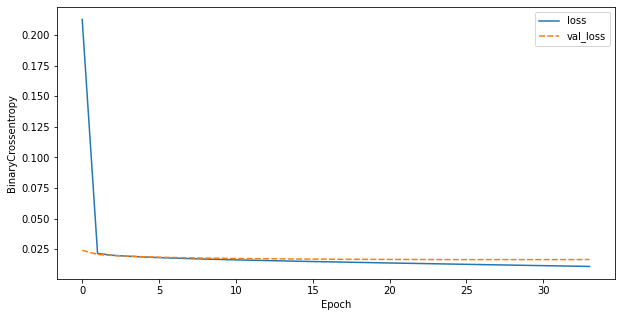

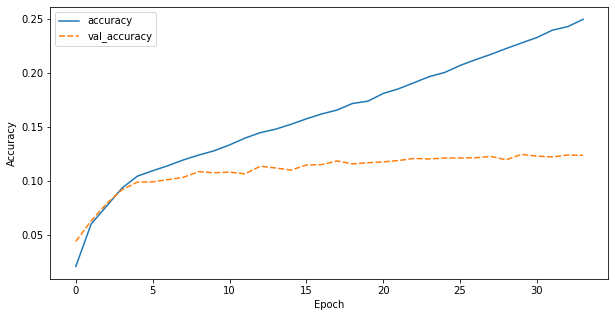

In [159]:
df_hist = pd.DataFrame(
    data=hist.history
)

plt.figure(figsize=(10, 5))
ax = sns.lineplot(
    data=df_hist[['loss', 'val_loss']]
)
ax.set(xlabel='Epoch', ylabel='BinaryCrossentropy')
plt.show()

plt.figure(figsize=(10, 5))
ax = sns.lineplot(
    data=df_hist[['accuracy', 'val_accuracy']]
)
ax.set(xlabel='Epoch', ylabel='Accuracy')
plt.show()

###Análise dos resultados

Analisando os gráficos de treino do modelo, ele claramente sofreu de overfitting, onde o modelo "decorou" os dados de treino ao invés de aprender os padrões nos dados.

### Novo modelo mais sofisticado
Na literatura, o modo mais simples de lidar com overfitting costuma ser inserindo layers de Dropout.

Layers de dropout forçam a rede nerual a ignorar alguns valores de ativação aleatoriamente durante o treino. Isso torna a fase de aprendizado mais lenta, mas evita que a rede "decore" os dados e sofra overfitting.

Além disso, vamos adicionar layers de BatchNormalization, que são muito comuns nas aplicações de deeplearning. Estes layers normalizam os dados numericamente entre uma camada e outra da rede para uma melhor estabilidade numérica na fase de "backpropagation".

In [162]:
def make_modelo(n_sources, n_targets):
    model = tf.keras.Sequential([
        tf.keras.layers.Input(n_sources),
        tf.keras.layers.Dense(1024, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(768, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(512, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(n_targets, activation='sigmoid')
    ])

    optmizer = tf.keras.optimizers.Adam(
        learning_rate=1e-5
    )

    model.compile(
        optimizer=optmizer,
        loss=tf.keras.losses.BinaryCrossentropy(),
        metrics=['accuracy']
    )

    return model

n_sources = len(dados.loc[:, 'g-0':'c-99'].columns)
n_targets = len(dados.loc[:, '11-beta-hsd1_inhibitor':'nrf2_activator'].columns)
modelo = make_modelo(n_sources, n_targets)
modelo.summary()

Model: "sequential_35"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_142 (Dense)            (None, 1024)              893952    
_________________________________________________________________
batch_normalization_33 (Batc (None, 1024)              4096      
_________________________________________________________________
dropout_39 (Dropout)         (None, 1024)              0         
_________________________________________________________________
dense_143 (Dense)            (None, 768)               787200    
_________________________________________________________________
batch_normalization_34 (Batc (None, 768)               3072      
_________________________________________________________________
dropout_40 (Dropout)         (None, 768)               0         
_________________________________________________________________
dense_144 (Dense)            (None, 512)             

In [163]:
modelo = make_modelo(n_sources, n_targets)
hist = modelo.fit(
    x=x_treino,
    y=y_treino,
    batch_size=32,
    validation_data=(x_teste, y_teste),
    epochs=100, callbacks=callbacks
)   

Epoch 1/100
596/596 [==============================] - 4s 5ms/step - loss: 0.8797 - accuracy: 0.0093 - val_loss: 0.7616 - val_accuracy: 0.0231
Epoch 2/100
596/596 [==============================] - 3s 5ms/step - loss: 0.8275 - accuracy: 0.0132 - val_loss: 0.7282 - val_accuracy: 0.0372
Epoch 3/100
596/596 [==============================] - 3s 5ms/step - loss: 0.7830 - accuracy: 0.0159 - val_loss: 0.7021 - val_accuracy: 0.0439
Epoch 4/100
596/596 [==============================] - 3s 5ms/step - loss: 0.7459 - accuracy: 0.0206 - val_loss: 0.6769 - val_accuracy: 0.0462
Epoch 5/100
596/596 [==============================] - 3s 5ms/step - loss: 0.7150 - accuracy: 0.0178 - val_loss: 0.6502 - val_accuracy: 0.0435
Epoch 6/100
596/596 [==============================] - 3s 5ms/step - loss: 0.6833 - accuracy: 0.0183 - val_loss: 0.6185 - val_accuracy: 0.0443
Epoch 7/100
596/596 [==============================] - 3s 5ms/step - loss: 0.6484 - accuracy: 0.0179 - val_loss: 0.5823 - val_accuracy: 0.0445

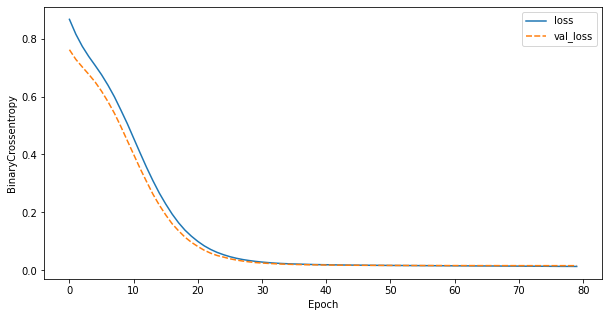

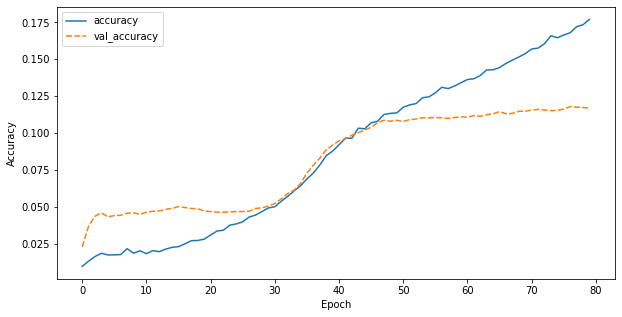

In [164]:
df_hist = pd.DataFrame(
    data=hist.history
)

plt.figure(figsize=(10, 5))
ax = sns.lineplot(
    data=df_hist[['loss', 'val_loss']]
)
ax.set(xlabel='Epoch', ylabel='BinaryCrossentropy')
plt.show()

plt.figure(figsize=(10, 5))
ax = sns.lineplot(
    data=df_hist[['accuracy', 'val_accuracy']]
)
ax.set(xlabel='Epoch', ylabel='Accuracy')
plt.show()